# Challenge - Internal quality prediction of pears using NIR spectra

This challenge consists in a deep learning model or other type of machine learning model aimed at the prediction of two internal quality parameters of pears, namely the soluble solids content (SSC) usually refered to as brix, and firmness. The data consists of NIR raw (and preprocessed) spectra of pears (the independent variables X) and the corresponding values of SSC and firmness obtained from wet chemistry measurements (the target variables, Y). This is a regression problem because we want to predict a continuous variable (either brix or firmness).

Use the train data to develop your model and submit your predictions for the test data. The performance metric is the mean squared error (MAE) between the predicted and true values of the target variables.
The predictions should be saved in a .csv file (one per target variable) before submission.
The true values of the target variables for the test data are not provided and will be used to evaluate the performance of your model after submission.

## Import main libraries

In [1]:
from sys import stdout
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns 
from scipy.signal import savgol_filter
from scipy import stats


# from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler, RobustScaler
from sklearn.cross_decomposition import PLSRegression, PLSCanonical, CCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score , KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
#     cross_validate, StratifiedKFold


## Import the files in .csv format in the challenge_data folder. We can use Pandas to read the files.

**Files description**

The `x_train.csv`, `x_test.csv` contain the raw spectra (photon counts per channel) while the `x_2d_snv_train.csv` and `x_2d_snv_test.csv` contain a preprocessed (a.k.a. pre-treated) version of the spectra. The preprocessing applied was a smooth second derivative (Savitzky-Golay derivative) followed byt SNV (Standard Normal Variate). This type of preprocessing step in common in spectroscopy and helps to remove baseline effects in the spectra and to enhance spectral features. The first row in these files corresponds to the spectral feature number (that can be mapped to the wavelength) and the first column corresponds a code corresponding to the sample number. These matrices contain 3204 samples (rows) and 874 features (columns).

The `y_brix_train.csv` and `y_brix_test.csv` contain the target variable: **brix** (sugar content) of the samples. The first column corresponds to the sample number. \
The `y_firm_train.csv` and `y_firm_test.csv` contain the target variable: **firmness** of the samples. The first column corresponds to the sample number.\
These matrices contain 3204 samples (rows) and 1 feature (column).

In [2]:
## Path to the data folder
data_dir = 'challenge_data/'

## Import training data (raw spectra and pre-processed spectra)
x_train = pd.read_csv(data_dir + 'x_train.csv', index_col=0)
x_2d_snv_train = pd.read_csv(data_dir + 'x_2d_snv_train.csv', index_col=0)
## Import the target values to predict
brix_train = pd.read_csv(data_dir + 'y_brix_train.csv', index_col=0)
firm_train = pd.read_csv(data_dir + 'y_firm_train.csv', index_col=0)

## Import test data (raw spectra and pre-processed spectra) to create final predictions
x_test = pd.read_csv(data_dir + 'x_test.csv', index_col=0)
x_2d_snv_test = pd.read_csv(data_dir + 'x_2d_snv_test.csv', index_col=0)

## Import the wavelengths of the spectra (useful for plotting purposes)
wavelengths = pd.read_csv(data_dir + 'wavelengths.csv', index_col=None, names=['wavelengths'])

Data visualization example

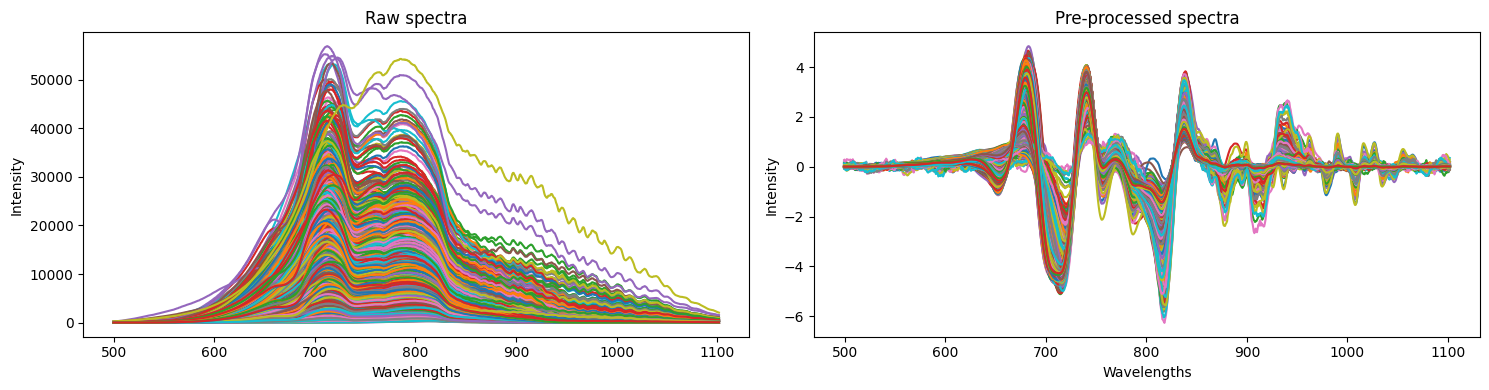

In [3]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(wavelengths, x_train.T)
plt.title('Raw spectra')
plt.xlabel('Wavelengths')
plt.ylabel('Intensity')
plt.subplot(1, 2, 2)
plt.plot(wavelengths, x_2d_snv_train.T)
plt.title('Pre-processed spectra')
plt.xlabel('Wavelengths')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

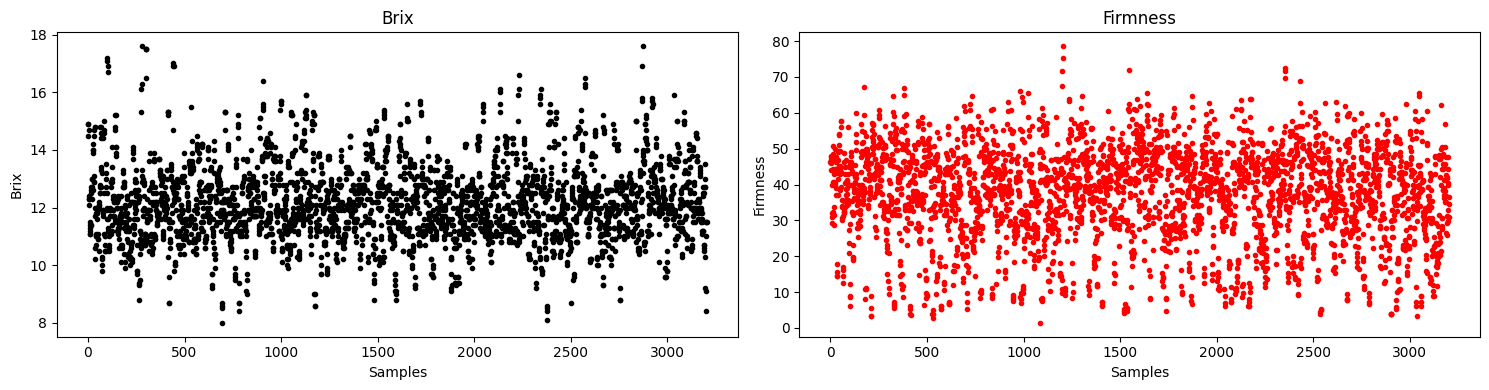

In [4]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(brix_train.values,'k.')
plt.title('Brix')
plt.xlabel('Samples')
plt.ylabel('Brix')
plt.subplot(1, 2, 2)
plt.plot(firm_train.values, 'r.')
plt.title('Firmness')
plt.xlabel('Samples')
plt.ylabel('Firmness')
plt.tight_layout()
plt.show()

## Examples of model training and prediction

It is advised to split the training data into two subsets: train and validation. The train subset is used to train the model and the validation subset is used to evaluate the model performance. This is a common practice in machine learning to avoid overfitting and for model hyperparameter tuning. In this case we will use 80% of the data for training and 20% for validation. 

In [5]:
X_train, X_val, X_2D_SNV_train, X_2D_SNV_val, BRIX_train, BRIX_val, FIRM_train, FIRM_val = train_test_split(x_train, x_2d_snv_train, brix_train, firm_train, test_size=0.2, random_state=42)

### Level 1: Simple linear regression model

Since this is a multivariate regression problem, we can use a simple linear regression model as a baseline. We can use the `LinearRegression` class from the `sklearn.linear_model` module. Here is an example of how to train a linear regression model, apply it to X_train and make predictions.

In [6]:
## Fit a multi-linear regression model to predict the Brix values
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X_train, BRIX_train)

## Use the model for predictions
brix_train_pred1 = model1.predict(X_train)
brix_val_pred1 = model1.predict(X_val)

## Compute the R2 score and the RMSE of the train and validation sets
r2_train1 = model1.score(X_train, BRIX_train)
r2_val1 = model1.score(X_val, BRIX_val)
rmse_train1 = np.sqrt(mean_squared_error(BRIX_train, brix_train_pred1))
rmse_val1 = np.sqrt(mean_squared_error(BRIX_val, brix_val_pred1))

print('R2 train:', r2_train1)
print('R2 val:', r2_val1)
print('RMSE train:', rmse_train1)
print('RMSE val:', rmse_val1)

R2 train: 0.7526268192927189
R2 val: 0.2755275788070075
RMSE train: 0.6600160821884421
RMSE val: 1.1381847912973397


We can use this as baseline to further improve. We can also plot how the predicted values compare to the true values in the validation set. This can be done using a scatter plot where the x-axis corresponds to the true values and the y-axis corresponds to the predicted values. If the model is perfect, the points should lie on a straight line with slope 1.

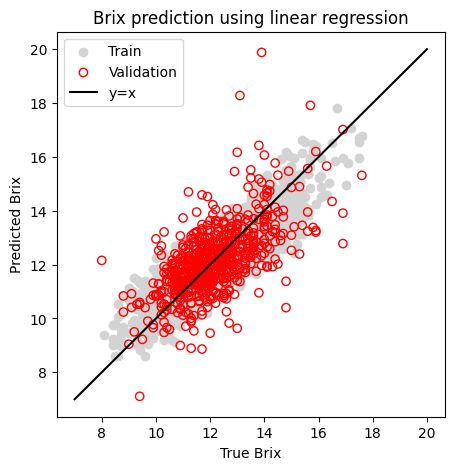

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(BRIX_train, brix_train_pred1, color='lightgray', marker='o', linestyle='None')
plt.scatter(BRIX_val, brix_val_pred1, color='r', marker='o', facecolors='None')
plt.plot([7,20], [7,20], 'k')
plt.xlabel('True Brix')
plt.ylabel('Predicted Brix')
plt.title('Brix prediction using linear regression')
plt.legend(['Train','Validation', 'y=x'])
plt.show()

Now that we have our model we should predict the test set and save the results in a .csv file preserving the order of the samples. This is the file that should be sent for submission.

In [8]:
## make predictions using model 1 on the test set
brix_test_pred1 = model1.predict(x_test)
## convert the predictions to a DataFrame, add the correct index and save the predictions to a csv file
brix_test_pred1_df = pd.DataFrame(brix_test_pred1, index=x_test.index, columns=['brix'])
brix_test_pred1_df.to_csv('brix_test_pred1.csv')


### Level 2: Partial Least Squares (PLS) regression model

In this example we will use one of the most used algorithms in chemometrics, the Partial Least Squares (PLS) regression. We can use the `PLSRegression` class from the `sklearn.cross_decomposition` module. Here is an example of how to train a PLS regression model and make predictions.

In [9]:
## Fit PLS regression model to predict the Brix values
model2 = PLSRegression(n_components=8)
model2.fit(X_train, BRIX_train)

## Use the model for predictions
brix_train_pred2 = model2.predict(X_train)
brix_val_pred2 = model2.predict(X_val)

## Compute the R2 score and the RMSE of the train and validation sets
r2_train2 = model2.score(X_train, BRIX_train)
r2_val2 = model2.score(X_val, BRIX_val)
rmse_train2 = np.sqrt(mean_squared_error(BRIX_train, brix_train_pred2))
rmse_val2 = np.sqrt(mean_squared_error(BRIX_val, brix_val_pred2))

print('R2 train:', r2_train2)
print('R2 val:', r2_val2)
print('RMSE train:', rmse_train2)
print('RMSE val:', rmse_val2)


R2 train: 0.23515549835569594
R2 val: 0.20040213664812578
RMSE train: 1.1605524846598603
RMSE val: 1.1957424897179108


**Comment:** This prediction using PLS is worse than the linear regression model. But what happens if you use the preprocessed data (X_2D_SNV_train)? Also, in the case of the linear regression, we didn't had any model hyperparameters to optimize. In the case of PLS we should optimize the number of latent variables or components (n_components) to use. This can be done by evaluating the model performance in the validation set for different values of n_components. We can then choose the value that gives the best performance. Each "component" or "latent variable" is a linear combination of the original features that captures the maximum variance in the target variable. For this type of data, using n_components above 15 or 20 is usually not recommended (as we start to model noise and other unwanted effects).

### Level 3: Deep learning model (CNN)

In this case we will use a simple Convolutional Neural Network (CNN) to predict the target variables. We can use the `Sequential` class from the `tensorflow.keras.models` module to build the model. Here is an example of how to build a simple CNN model and train it. This is a bit more advanced and herein lies the challenge (and potential benefits).

In [10]:
## Import tensorflow and keras
import sys
import random
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape


## This is a useful function to set the random seed for reproducibility across different libraries
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

## Here is a custom callback to keep track of the training progress
class PrintValLossInlineCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            val_loss = logs.get('val_loss')
            loss = logs.get('loss')
            if val_loss is not None:
                # Print the val_loss inline
                sys.stdout.write(f"\rEpoch {epoch + 1}: loss= {loss:.4f} \t val_loss = {val_loss:.4f}")


Next we implement the CNN model. Some remarks before the implementation done here:
<br>

- **Weights initialization:** The authors mention that "*the weights are initialized by a zero-mean Gaussian distribution whose standard deviation is $\sqrt{\frac{2}{n_i}}$, where $n_i$ is the number of input neurons*". This corresponds to <code>he_normal()</code> initializer in tf.keras.



- **Loss function:** The loss function used by *Cui, Fearn 2018* is $Loss = MSE + \frac{1}{2} \lambda \sum{w_i^2}$, i.e. the mean squared error (MSE) plus an L2 penalty $\lambda$ on the weights $w_i$. Instead of crafting a custom loss function we can achieve the same result by implementing L2 regularization. According to [Keras documentation](https://keras.io/api/layers/regularizers/) "*Regularizers allow you to apply penalties on layer parameters (e.g. weights) during optimization. These penalties are summed into the loss function that the network optimizes*". Therefore we will choose the loss function as <code>'mse'</code> and apply an L2 regularization to the weights (by using <code> tf.keras.regularizers.l2(beta))</code>. The regularization hyperparameter $\lambda$ mentioned in the paper is related to keras $\beta$ as $\beta=\frac{\lambda}{2}$ (see [tf.keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2)). 


- **Optimizer:** We use the Adam optimizer here. In the paper, the authors use the Adam optimizer for dataset 1 and 2 but for dataset 3 they used the L-BFGS second-order optimizer for full batch optimization. Since Tensorflow does not provide a native L-BFGS optimizer we proceed with Adam. In the next section of this notebook I'll show a possible alternative implementation of L-BFGS optimization.

In [11]:
## Make computations reproducible
reproducible_comp()

## Define the CNN model architecture. We will allow the user to input the L2 regularization parameter
def init_model(reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_train)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_STRIDE = 1
    FC1_DIMS = 128

    ## L2 regularizer parameter
    beta= reg_beta

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Due to this, we might have to re-run this cell before each experiment to ensure proper weight initialization each time
    K_INIT = tf.keras.initializers.he_normal(seed=42)

    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)


    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                ## first convolutional layer with 4 filters and a kernel size of 16
                                keras.layers.Conv1D(filters=4, \
                                                    kernel_size=16, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='relu',\
                                                    input_shape=(CONV1D_DIMS,1)), 
                                ## add a max pooling layer for feature reduction
                                #keras.layers.MaxPooling1D(pool_size=2, strides=2), 
                                ## second convolutional layer with 8 filters and a kernel size of 8
                                keras.layers.Conv1D(filters=8, \
                                                    kernel_size=8, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='relu',\
                                                    input_shape=(CONV1D_DIMS,1)),
                                ## add a max pooling layer for feature reduction
                                keras.layers.MaxPooling1D(pool_size=8, strides=4),                    
                                ## flatten the output of the convolutional layers
                                keras.layers.Flatten(),
                                ## add a fully connected layer
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='relu'),
                                ## add the output layer for regression with a linear activation function
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear'),
                              ])
    return(model_cnn)

Lets check the model structure:

In [12]:
## initialize a model with L2 = 0.01
cnn_model = init_model(0.01)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 874, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 874, 4)            68        
                                                                 
 conv1d_1 (Conv1D)           (None, 874, 8)            264       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 217, 8)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1736)              0         
                                                                 
 dense (Dense)               (None, 128)               222336    
                                                        

Now we create a training loop for the architecture and train the CNN on the train data, while using the validation split to monitor for overfitting.

Adam learning rate = 0.005
Epoch 470: loss= 0.5797 	 val_loss = 1.0374Model training complete!


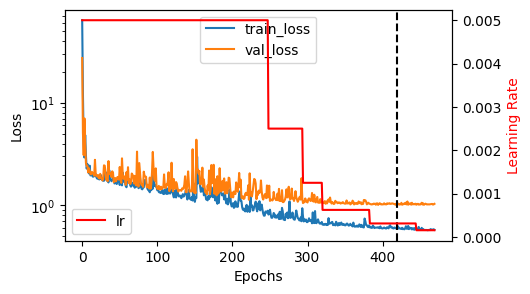

In [13]:
BATCH = 128  ## batch size for training
BETA = 0.001 ## L2 regularization parameter
models_dir = 'challenge_models/' ## directory to save the trained models
MODEL_NAME = models_dir+'cnn_firm_'+str(BATCH)+'_'+str(BETA)+'.h5' ## model name for saving trained model weights. Can be .h5 or .keras (for recent keras versions)

## empirical learning rate value for Adam optimizer
LR=0.01*BATCH/256.

## initialize the model
model_cnn=init_model(BETA)
print('Adam learning rate = {}'.format(LR))
## compile the model with Adam optimizer and mean squared error loss
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])  
    
#### We can play around with different the following methods to check for improvements. In this base notebook only checkpoint is used! 
### 1) Stop the training if it does not improve
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
### 2) Reduce learning rate dynamically
rdlr = keras.callbacks.ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
### 3) Save the best weights into file
checkpointer= keras.callbacks.ModelCheckpoint(filepath=MODEL_NAME, verbose=0, save_best_only=True)
## monitor the training progress
print_val_loss = PrintValLossInlineCallback()

## Before feeding the data to the model it is some times useful to standardize the x_data and scale the y_data. In this case we will only standardize the x_data using sklearn's StandardScaler
x_scaler = StandardScaler()
x_scaler.fit(X_train)
x_train_scaled = x_scaler.transform(X_train)
## the val and test data are scaled using the same scaler as the train data
x_val_scaled = x_scaler.transform(X_val)
x_test_scaled = x_scaler.transform(x_test)


## Train the model
h = model_cnn.fit(x_train_scaled, BRIX_train, batch_size=BATCH, epochs=500, \
                  validation_data=(x_val_scaled, BRIX_val),  \
                  callbacks=[checkpointer, rdlr, early_stop, print_val_loss],verbose=0)


## Load the best weights into the model
model_cnn.load_weights(MODEL_NAME)

## Plot the training history. Useful to check for overfitting and underfitting
print('Model training complete!')
plt.figure(figsize=(5,3))
plt.plot(h.history['loss'], label='train_loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.axvline(early_stop.best_epoch, color='k', linestyle='--', label='early stop')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
## add secondary y axis for the learning rate
plt.twinx()
plt.plot(h.history['lr'], 'r', label='lr')
plt.ylabel('Learning Rate', color='r')
plt.legend(loc='lower left')
plt.show()

## clear the session to free up memory    
tf.keras.backend.clear_session()

There is a lot of noise in the training and validation loss. Can we improve this?. Maybe the LR is not adequate? Or the architecture is not optimized?

Lets check our predictions for the train, val and test data.

In [14]:
## Remember to use the scaled data for predictions
brix_train_pred3 = model_cnn.predict(x_train_scaled)
brix_val_pred3 = model_cnn.predict(x_val_scaled)

## Compute the R2 score and the RMSE of the train and validation sets. Note that unlike the sklearn models, the keras model does not have a built-in score method
## Therefore we have to compute the R2 and RMSE manually
r2_train3 = r2_score(BRIX_train, brix_train_pred3)
r2_val3 = r2_score(BRIX_val, brix_val_pred3)
rmse_train3 = np.sqrt(mean_squared_error(BRIX_train, brix_train_pred3))
rmse_val3 = np.sqrt(mean_squared_error(BRIX_val, brix_val_pred3))

print('\n\nR2 train:', r2_train3)
print('R2 val:', r2_val3)
print('RMSE train:', rmse_train3)
print('RMSE val:', rmse_val3)

21/21 [==============================] - 0s 900us/step


R2 train: 0.7350693423335032
R2 val: 0.5082294754918661
RMSE train: 0.6830371416169146
RMSE val: 0.9377414145354362


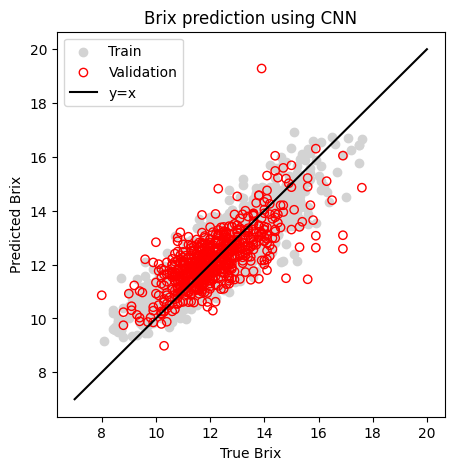

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(BRIX_train, brix_train_pred3, color='lightgray', marker='o', linestyle='None')
plt.scatter(BRIX_val, brix_val_pred3, color='r', marker='o', facecolors='None')
plt.plot([7,20], [7,20], 'k')
plt.xlabel('True Brix')
plt.ylabel('Predicted Brix')
plt.title('Brix prediction using CNN')
plt.legend(['Train','Validation', 'y=x'])
plt.show()

This un-optimized CNN model beats the other two models. Can we improve it further? Maybe by optimizing the learning rate, the architecture, the number of epochs, the batch size, the regularization hyperparameter, etc. This is the challenge!

In [16]:
## finally make predictions on the test set and save the predictions to a csv file
brix_test_pred3 = model_cnn.predict(x_test_scaled)
brix_test_pred3_df = pd.DataFrame(brix_test_pred3, index=x_test.index, columns=['brix'])
brix_test_pred3_df.to_csv('brix_test_pred3.csv')


26/26 [==============================] - 0s 1ms/step


**Final notes:**<br>
From the side of Deep Learning, CNNs are the most used architecture for this kind of regression problem. However, there are other architectures that can be explored (ResNets, CNNs with attention, graph neural networks, etc.). Also beyond deep learning, there are other types of machine learning models (e.g. xgboost, etc.) that can be used but are not very common to find in the chemometrics literature.


**Tips and tricks:**<br>
- **Data preprocessing:** The data can be preprocessed in many ways. For example, the spectra can be smoothed, normalized, baseline corrected, etc. If you want you can try to preprocess the spectral data in different ways and see how it affects the model performance.
- **Feature selection:** You can try to select the most important features (wavelengths) to reduce the dimensionality of the data. This can be done using feature selection algorithms or by using domain knowledge.
- **Hyperparameter optimization:** You can try to optimize the hyperparameters of the model (e.g. learning rate, number of layers, number of neurons, etc.) using grid search, random search, Bayesian optimization, etc.
- **Outlier removal:** You can try to remove outliers from the data to improve the model performance. This can be done using statistical methods or using other machine learning models.
- **Ensemble methods:** You can try to combine multiple models to improve the model performance. This can be done using ensemble methods such as bagging, boosting, stacking, etc.
- **Use cross-validation strategies:** You can use cross-validation strategies to evaluate the model performance and to avoid overfitting. This can be done using k-fold cross-validation, leave-one-out cross-validation, etc.
